# Calculating GB energy from DF

## Objective

(i) Select data from boundaries
(ii) Organize it for all grains
(iii) Calculate the energy with wield

## Method

    * Open Dataframe
    * Select attributes of interest from boundaries
    * Create a new DF with grain information
    * Convert data to wield
    * Run wield for all grains
    * Store energy in Dataframe

In [1]:
import pandas as pd
import numpy as np
from skimage import draw,io
from skimage.segmentation import flood, flood_fill
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import cv2
from matplotlib import pyplot as plt

from IPython.display import set_matplotlib_formats
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200


### Open Dataframe


In [2]:

folder = "../data/"
file = "1_001"
path = folder + file

#%%

sample = np.loadtxt(path+ ".txt")

'''
# Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
# Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
# Column 7:     Misorientation Angle
# Column 8-10:  Misorientation Axis in Right Hand grain
# Column 11-13: Misorientation Axis in Left Hand grain
# Column 14:    length (in microns)
# Column 15:    trace angle (in degrees)
# Column 16-19: x,y coordinates of endpoints (in microns)
# Column 20-21: IDs of right hand and left hand grains

'''


df = pd.DataFrame(  data = sample, 
                    columns = ["right_phi1","right_PHI","right_phi2",                 #1-3
                               "left_phi1","left_PHI","left_phi2",                    #4-6 
                               "ori_angle",                                           #7
                               "right_ori_x","right_ori_y","right_ori_z",              #8-10
                               "left_ori_x","left_ori_y","left_ori_z",                 #11-13  
                               "length",                                              #14
                               "trace_angle",                                         #15
                               "x_start", "y_start", "x_end", "y_end",                #16-19
                               "grain_right","grain_left"                             #20-21
                               ]                    
                 )


In [3]:
df.grain_right.drop_duplicates(keep = False)

3        149.0
6        216.0
7        264.0
9        286.0
12       381.0
         ...  
3918    1229.0
3926    2569.0
3929     291.0
3931     495.0
3933     604.0
Name: grain_right, Length: 250, dtype: float64

### Select attributes of interest from boundaries

The group of information that is directly related to the grain: 
* Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
* Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
* Column 7:     Misorientation Angle
* Column 8-10:  Misorientation Axis in Right Hand grain
* Column 11-13: Misorientation Axis in Left Hand grain
* Column 20-21: IDs of right hand and left hand grains

The Columns 20-21 describe the grain of interest

The Columns 1-6 depends on grain itself, **here we are interested**

The Columns 7-13 depends on left and right grains

In [4]:
#df_left = df[['ori_angle','left_phi1','left_PHI','left_phi2','left_ori_x','left_ori_y','left_ori_z','grain_left']]
#df_right = d|f[['right_phi1','right_PHI','right_phi2','right_ori_x','right_ori_y','right_ori_z','grain_right']]

# left_ori is related with other grain, than is not interesting to keep in this case

df_left = df[['left_phi1','left_PHI','left_phi2','grain_left']]
df_left = df_left.rename(columns={"grain_left": "grain"})


df_right = df[['right_phi1','right_PHI','right_phi2','grain_right']]
df_right = df_right.rename(columns={"grain_right": "grain"})


In [5]:
df_left = df_left[~df_left.grain.duplicated()].sort_values('grain')
df_left = df_left.set_index('grain')


In [6]:
df_right = df_right[~df_right.grain.duplicated()].sort_values('grain')
df_right = df_right.set_index('grain')


In [7]:
#df_grains = pd.concat([df_left,df_right])
df_grains = df_left.join(df_right)
df_grains_l = df_left.join(df_right)
df_grains_r = df_right.join(df_left)

In [8]:
df_grains_l.isnull().sum(),df_grains_r.isnull().sum()

(left_phi1      0
 left_PHI       0
 left_phi2      0
 right_phi1    51
 right_PHI     51
 right_phi2    51
 dtype: int64,
 right_phi1     0
 right_PHI      0
 right_phi2     0
 left_phi1     35
 left_PHI      35
 left_phi2     35
 dtype: int64)

In [9]:
df_grains.sort_values('grain')

,left_phi1,left_PHI,left_phi2,right_phi1,right_PHI,right_phi2
grain,,,,,,
1.0,5.039,0.678,1.946,5.039,0.678,1.946
2.0,0.241,0.410,6.087,0.241,0.410,6.087
3.0,0.259,0.637,6.253,0.259,0.637,6.253
4.0,4.502,0.759,1.253,4.502,0.759,1.253
5.0,4.443,0.631,1.231,4.443,0.631,1.231
...,...,...,...,...,...,...
2785.0,2.677,0.281,3.545,2.677,0.281,3.545
2786.0,6.142,0.384,0.133,6.142,0.384,0.133
2788.0,0.027,0.126,6.158,0.027,0.126,6.158


In [10]:
df_grains.isnull().sum()

left_phi1      0
left_PHI       0
left_phi2      0
right_phi1    51
right_PHI     51
right_phi2    51
dtype: int64

## Fill Grains based on phi1, PHI, and phi2

In [11]:
df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())

The method polygon_fill do not work because it uses the Even–odd rule and fill all closed paths based on directions provided as parameters. As the order or parameters meters and in our case is not ordered, this method is not helpful.


## Flood Fill method

## Closing opened grains

# New Method to draw and fill

### Order points in clockwise direction and than draw

In [12]:
import math

origin = [0, 0]
refvec = [0, 1]

def clockwiseangle_and_distance(point):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
   
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector

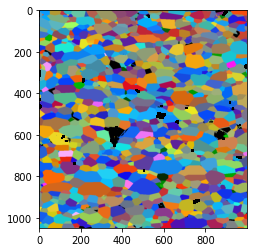

In [17]:


width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1

flooded_grains = np.zeros([height, width, 3])
overflood = np.sum(flooded_grains==0) * 0.8
over = []

for grain in df_grains.index:
        One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
        grain_info = df_grains_norm.loc[grain,:]
        np_img = np.zeros([height, width, 3])

        #  width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
        #  height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

        x_center = math.floor(One_grain[['x_start','x_end']].mean().mean())
        y_center = math.floor(One_grain[['y_start','y_end']].mean().mean())


       # if(x_center < 200 and y_center < 200): 
        phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
        #    cv2.putText(np_img, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.4, color=(255,255,255), thickness=1)

        for idx, row in One_grain.iterrows():

            rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
            np_img[cc,rr] = (1,1,1)

        mask = flood(np_img, (y_center, x_center,0))
        #        print(str(grain) + " len "+ str(np.count_nonzero(mask)))
        #        print(str(grain) + " len 0 "+ str(np.sum(mask==1)))
        np_img[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]

        if (np.sum(mask==1)<overflood):
            flooded_grains[mask[:,:,1] !=0] = [phi1,Phi,phi2]
            flooded_grains[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]




        else:
            over.append(grain)
            
            One_grain = One_grain[One_grain["length"]>10]

            start = pd.DataFrame(columns=["x","y"])
            end = pd.DataFrame(columns=["x","y"])
            start[["x","y"]] = One_grain[['x_start','y_start']]
            end[["x","y"]] = One_grain[['x_end','y_end']]
            points = pd.concat([start,end])

            p = points.drop_duplicates()
            p1 = p.to_numpy()

            origin = [x_center,y_center]
            sort = sorted(p1, key=clockwiseangle_and_distance)
            a = []
            for b in sort:
                a.append(tuple((int(b[0]),int(b[1]))))

            cv2.polylines(np_img, np.array([a]), True, (phi1,Phi,phi2), 2)
            

            mask = flood(np_img, (y_center, x_center,0))
            if(np.sum(mask==1)<overflood):
#                np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
#                 cv2.imshow('f',flooded_grains)
#                 cv2.waitKey(0)
#                 cv2.destroyAllWindows()
                
                flooded_grains[mask[:,:,1] !=0] = [phi1,Phi,phi2]
                flooded_grains[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]


        
        
plt.imshow(flooded_grains)



In [14]:
plt.imshow(flooded_grains)

NameError: name 'flood_grains' is not defined

In [ ]:
cv2.imshow('f',flood_grains)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
width/height

In [ ]:
1084/1024

In [ ]:
sort = sorted(p1, key=clockwiseangle_and_distance)
a = []
for b in sort:
    a.append(tuple((int(b[0]),int(b[1]))))

In [ ]:
# pts = [(50, 50), (300, 190), (400, 10)]
# pt = [(1, 1150), (2, 1154), (3, 1194),(1, 1153),(1, 1160), (1, 1173),(1, 1180),(1, 1184), (1, 1188)]
# np.shape(pt)

In [ ]:
One_grain = One_grain[One_grain["length"]>5]

In [ ]:

width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1

flood_grains = np.zeros([height, width, 3])
overflood = np.sum(flood_grains==0) * 0.8
print(overflood)

#for grain in over:
grain = 273

One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]

One_grain = One_grain[One_grain["length"]>10]

grain_info = df_grains_norm.loc[grain,:]
np_img = np.zeros([height, width, 3])

#  width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
#  height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

x_center = math.floor(One_grain[['x_start','x_end']].mean().mean())
y_center = math.floor(One_grain[['y_start','y_end']].mean().mean())


# if(x_center < 200 and y_center < 200): 
phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
#    cv2.putText(np_img, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.4, color=(255,255,255), thickness=1)


over.append(grain)

start = pd.DataFrame(columns=["x","y"])
end = pd.DataFrame(columns=["x","y"])
start[["x","y"]] = One_grain[['x_start','y_start']]
end[["x","y"]] = One_grain[['x_end','y_end']]
points = pd.concat([start,end])

p = points.drop_duplicates()
p1 = p.to_numpy()

origin = [x_center,y_center]
sort = sorted(p1, key=clockwiseangle_and_distance)
a = []
for b in sort:
    a.append(tuple((int(b[0]),int(b[1]))))

cv2.polylines(np_img, np.array([a]), True, (255,255,255), 2)

mask = flood(np_img, (y_center, x_center,0))
#     cv2.imshow('f',np_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
flood_grains += np_img


plt.imshow(flood_grains)#[340:400,1050:1150])





In [ ]:
grain = 273
width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1
np_img = np.zeros([height, width, 3])

One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]

for idx, row in One_grain[["x_start","y_start","x_end","y_end"]].astype('int32').iterrows():
    rr,cc = draw.line(row.x_start,row.y_start,row.x_end,row.y_end)

    np_img[cc,rr] = (255,255,255)

In [ ]:
plt.imshow(np_img)